In [1]:
import numpy as np
import os
import random
from sys import platform as sys_pf
import matplotlib
if sys_pf == 'darwin':
	matplotlib.use("TkAgg")
from matplotlib import pyplot as plt

import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Conv2D, MaxPooling2D, Dense, Concatenate, Dot, Lambda, Input
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from keras import backend as K
import h5py

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Some utility functions 

In [2]:
def load_img(fn):
	I = plt.imread(fn)
	I = np.array(I)
	return I
# convert to str and add leading zero to single digit numbers
def num2str(idx):
	if idx < 10:
		return '0'+str(idx)
	return str(idx)

Practise loading a random image from our dataset

generating figure 1 of 1


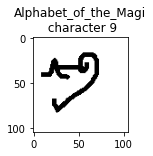

In [3]:
num_alphabets = 1
num_samples = 1
img_dir = r'C:\Users\Admin\few_shot_learning\keras-one-shot\images_background'
alphabet_names = [a for a in os.listdir(img_dir) if a[0] != '.'] # get folder names

for a in range(num_alphabets): # for each alphabet
        print('generating figure ' + str(a+1) + ' of ' + str(num_alphabets))
        alpha_name = alphabet_names[a]
        
        # choose a random character from the alphabet
        character_id = random.randint(1,len(os.listdir(os.path.join(img_dir,alpha_name))))

        # get image directory for this character
        img_char_dir = os.path.join(img_dir,alpha_name,'character'+num2str(character_id))


        # get base file name for this character
        fn_example = os.listdir(img_char_dir)[0]
        fn_base = fn_example[:fn_example.find('_')] 

        plt.figure(a,figsize=(10,8))
        plt.clf()
        for r in range(1,num_samples+1): # for each rendition
            plt.subplot(4,5,r)
            fn_img = img_char_dir + '/' + fn_base + '_' + num2str(r) + '.png'			
            I = load_img(fn_img)
            np.set_printoptions(threshold=np.inf)
            plt.imshow(I, cmap='gray')
            if r==1:
                plt.title(alpha_name[:20] + '\n character ' + str(character_id))


more utility functions to load pixel data for each image in an alphabet and make pairs of images for training

In [4]:
def load_imgs(alphabet_names):
    X = np.array([])
    Y = np.array([])
    for alpha_name in alphabet_names:
        char_ids = range(1,len(os.listdir(os.path.join(img_dir,alpha_name))) + 1)
        # get image directory for this character
        for char_id in char_ids:
            img_char_dir = os.path.join(img_dir,alpha_name,'character'+num2str(char_id))
            # get list of individual file names for each sample of a character
            img_fns = os.listdir(img_char_dir)
            # np arrays containing data of all samples of a character
            data = np.array([plt.imread(os.path.join(img_char_dir, fn)) for fn in img_fns])
            for i in range(len(img_fns)):
              Y = np.append(Y, alpha_name + '_character'+num2str(char_id)) # within alphabet discrimination
              # Y = np.append(Y, alpha_name) # between alphabet discrimination
            if X.size == 0:
                X = data
            else:
                X = np.vstack((X, data))

        
    return X, Y

def make_pairs(X, Y):

    pairs = []
    labels = []

    for i in range(len(X)):
        if i%1000 == 0:
            print(i)
        # choose a matching sample
        x1 = X[i]
        class_ = Y[i]

        # get possible indices where x2 is same class as x1
        J = [j for j, y in enumerate(Y) if y == class_]
        j = np.random.choice(J)

        x2 = X[j]

        pairs += [[x1, x2]]
        labels += [1]

        # get non-match
        # get possible indices where x2 is different from x1
        J = [j for j, y in enumerate(Y) if y != class_]
        j = np.random.choice(J)

        x2 = X[j]

        pairs += [[x1, x2]]
        labels += [0]
        
    return np.array(pairs), np.array(labels)



Use our utility function to get training set and test set

In [5]:
def train_test_split(n, alphabet_names):

    train_alphabets = alphabet_names[:n]
    test_alphabets = alphabet_names[n:]

    X_train, Y_train = load_imgs(train_alphabets)
    train_pairs, train_labels = make_pairs(X_train, Y_train)

    X_test, Y_test = load_imgs(test_alphabets)

    return train_pairs, train_labels, X_test, Y_test

In [34]:
def save_data(train_pairs=[], train_labels=[], X_test=[], Y_test=[]):
    # save it once to allow load from file
    if len(train_pairs) > 0:
        with h5py.File('train_pairs.h5', 'w') as hf:
            hf.create_dataset('train_pairs', train_pairs.shape, h5py.h5t.STD_U8BE, data=train_pairs)
    
    if len(train_labels) > 0:
        with h5py.File('train_labels.h5', 'w') as hf:
            hf.create_dataset('train_labels', train_labels.shape, h5py.h5t.STD_U8BE, data=train_labels)

    if len(X_test) > 0:
        with h5py.File('X_test.h5', 'w') as hf:
            hf.create_dataset('X_test', X_test.shape, h5py.h5t.STD_U8BE, data=X_test)

    if len(Y_test) > 0:
        with h5py.File('Y_test.h5', 'w') as hf:
            hf.create_dataset('Y_test', Y_test.shape, data=Y_test) 

    print('saved all files!')
    return None


In [32]:
#load from file
def load_data():
    with h5py.File('train_pairs.h5', 'r') as hf:
        train_pairs = hf['train_pairs'][:]

    with h5py.File('train_labels.h5', 'r') as hf:
        train_labels = hf['train_labels'][:]

    with h5py.File('X_test.h5', 'r') as hf:
        X_test = hf['X_test'][:]

    with h5py.File('Y_test.h5', 'r') as hf:
        Y_test = hf['Y_test'][:]
    print('data loaded!')

    return train_pairs, train_labels, X_test, Y_test


In [8]:
train_pairs, train_labels, X_test, Y_test = train_test_split(20, alphabet_names)
print("split!")
print(type(train_pairs[0][0]))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
split!
<class 'numpy.ndarray'>


In [18]:
new_train_pairs = train_pairs.astype(np.uint8)


TypeError: Invalid shape (105,) for image data

In [39]:
print(Y_test[0])

Korean_character01


1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1

We can check if the above worked correctly by showing the image pairs and their corresponding label

In [ ]:
for i in range(10):
    
    fig = plt.figure()
    fig.suptitle(train_labels[i])
    plt.subplot(2,2,1)
    plt.imshow(train_pairs[i][0], cmap='gray')
    plt.subplot(2,2,2)
    plt.imshow(train_pairs[i][1], cmap='gray')

In [ ]:
print(X_train.shape)
x_pairs, x_labels = make_pairs(X_train, Y_train)

In [ ]:
x_pairs.shape

Create our model!

In [ ]:
def get_siamese_model(input_shape):
    """
        Model architecture
    """

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network

    model = Sequential()
    
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                    kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                    kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                        kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        bias_initializer=keras.initializers.RandomNormal(mean=0.5, stddev=0.01), 
                        kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        bias_initializer=keras.initializers.RandomNormal(mean=0.5, stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        bias_initializer=keras.initializers.RandomNormal(mean=0.5, stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(2048, activation='sigmoid',
                    kernel_regularizer=l2(1e-3),
                    kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.1),
                    bias_initializer=keras.initializers.RandomNormal(mean=0.5, stddev=0.01)))
    

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    # return the model
    return siamese_net  

In [ ]:
model = get_siamese_model((105,105,1))
optimizer = Adam(lr = 0.00009)
model.compile(loss = "binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

train our model!

In [ ]:
model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels[:], batch_size=16, epochs=10)

save our model!

In [ ]:
model.save('model_8.h5')

or we can load a model!

In [ ]:
from keras.models import load_model
fn = 'model_8.h5'
model = load_model(fn)
model.summary()
model.get_config()
# model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels[:], batch_size=16, epochs=2)

make a function to generate a random n-way-k-shot test (including query image and support set) to test our model

In [ ]:
def get_test(X_test, Y_test, N, K):
    from sklearn.utils import shuffle
    # get num_tests amount of queries and support sets (n way k shot)
    # final output is a list of lists of tuples. Each inner list is a test containing tuple pairs in the form: [(Q, s1), (Q, s2),..., (Q, sk)]
    # where Q is the query img and s1 to sk are k imgs of the support set
    # second output is a list of targets(answers)
    # init lists of queries and support sets

    support_set = []
    targets= np.zeros(N*K)
    test_classes = list(set(Y_test))
   
    # choose random index
    i = np.random.randint(0, len(X_test))

    # get query img and corresponding label
    query = X_test[i]
    label = Y_test[i]
    
    # get 1 * K pairs that is same class
    for k in range(K):
        pos_j = [j for j, class_ in enumerate(Y_test) if class_ == label]
        j = np.random.choice(pos_j)

        pair = [query, X_test[j]]
        targets[k] = 1
        support_set.append(pair)

    # get n-1 * K pairs that are of diff class
    test_classes.remove(label)

    support_classes = []
    for n in range(N-1):

        random_class = np.random.choice(test_classes)
        support_classes.append(random_class)        
    
        for k in range(K):
            
            pos_j = [j for j, class_ in enumerate(Y_test) if class_ == random_class]
            j = np.random.choice(pos_j)
            pair = [query, X_test[j]]
            support_set.append(pair)
            
        test_classes.remove(random_class)

   
    # shuffle support set and add to all support sets
    support_set, targets = shuffle(support_set, targets)

    return np.array(support_set), np.array(targets)
    

In [ ]:
def get_20_way_test(X_test, Y_test, test_alphabets):
    # choose random alphabet from test alphabets
    random_alphabet = np.random.choice(test_alphabets)
    # choose random char from 1-20 (improvement: change to range within chosen alphabet)
    random_char = np.random.choice(['character{}'.format(i) for i in range(1,21)])
    # the label of the query image
    label = random_alphabet+random_char

    # init
    support_set = []
    targets = np.zeros(20)
    
    # choose query image corresponding the chosen label
    i = np.random.choice([i for i, class_ in enumerate(Y_test) if class_ == label])
    query = X_test[i]
    
    # add as first item of support set 
    support_set.append([query, label])
    targets[0] = 1

    # all available classes for the support set 
    test_classes = ['{}character{}'.format(random_alphabet, num2str(i)) for i in range(1, 21)]

    # iterate through the list and add 1 random image from each class to support set (excluding the label)
    for item in test_classes:
        if item != label:
            j = np.random.choice([j for j, class_ in enumerate(Y_test) if class_ == item])
            pair = [query, X_test[j]]
            support_set.append(pair)

    # shuffle support set and targets 
    support_set, targets = shuffle(support_set, targets)

    return np.array(support_set), np.array(targets)
    


Create a model class for testing of our FSL model against 2 baselines (random guess and nearest neighbour) for validation

In [ ]:
class Predictor(object):

    def __init__(self):
        self.n_correct = 0
        self.num_tests = 0
        self.name = ''
        self.prediction = None
    
    def get_name(self):
        return self.name

    def get_n_correct(self):
        return self.n_correct

    def get_num_tests(self):
        return self.num_tests

    def get_prediction(self):
        return self.prediction

    def set_prediction(self, support_set, targets):
        # to be overridden by subclasses
        self.prediction = 0

    def update_score(self, support_set, targets, verbose):
        self.set_prediction(support_set, targets)
        if targets[self.get_prediction()] == 1:
            self.n_correct += 1
        self.num_tests += 1

        if verbose and self.get_num_tests() < 10:
            print('TEST {}'.format(self.get_num_tests()))
            print('{} GUESSED PAIR {}'.format(self.get_name(), self.get_prediction() + 1))
    
            if targets[self.get_prediction()] == 1:
                print("CORRECT")
            else:
                print("INCORRECT")
            print('\n')

    def calc_accuracy(self, N, K):
        acc = round((self.n_correct/self.num_tests) * 100, 2)
        print("{} Model achieved {}% accuracy on {} {}-way {}-shot tests".format(self.get_name(), acc, self.get_num_tests(), N, K))
        return acc
   



In [ ]:
class FSL(Predictor):

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.name = 'Few Shot Learning'
        self.probs = None
        
    def get_probs(self):
        return np.round(self.probs, 4) 

    def set_prediction(self, support_set, targets):
        probs = model.predict([support_set[:,0], support_set[:,1]])
        self.probs = probs
        self.prediction = np.argmax(probs)
        

In [ ]:
class Random(Predictor):

    def __init__(self):
        super().__init__()
        self.name = 'Random Guess'
       
   
    def set_prediction(self, support_set, targets):
        self.prediction = np.random.randint(0, len(support_set))
       


class Nearest_Neighbour(Predictor):

    def __init__(self):
        super().__init__()
        self.name = 'Nearest Neighbour'
 
    def set_prediction(self, support_set, targets):
        # picks the class of image in the support set which has min L1 distance from query image
        min_dist = 10e9
        prediction = None
        for i in range(len(support_set)):
            pair = support_set[i]
            curr_dist = np.linalg.norm(pair[0].flatten() - pair[1].flatten(), ord=1)
            if curr_dist < min_dist:
                min_dist = curr_dist
                prediction = i
        self.prediction = prediction

In [ ]:
def test_models(models, X_test, Y_test, num_tests, N, K, verbose = 0, baseline = 0):
    """function to test any or all of our models that belong to the same Model class on the same test set of
    N way K shot cases over num_test tasks. Use verbose=1 setting to output prediciton data and create relevant visualisations!"""

    print("Evaluating models on {} random {} way {} shot learning tasks ... \n".format(num_tests, N, K))
      
    for num in range(num_tests):
        
        support_set, targets = get_test(X_test, Y_test, N, K)
        for model in models:
            model.update_score(support_set, targets, verbose)

        if verbose and num < 5:
            for i in range(len(support_set)):
    
                fig = plt.figure()
                ax1 = fig.add_subplot(221)
                ax1.imshow(support_set[i][0], cmap='gray')
                ax2 = fig.add_subplot(222)
                ax2.imshow(support_set[i][1], cmap='gray')
                fig.suptitle('TEST {}, PAIR {}\nFSL: {}, actual: {}'.format(num + 1, i+1, models[0].get_probs()[i], targets[i]))

    
    for model in models:
        model.calc_accuracy(N, K)
    return None

In [ ]:
models = [FSL(model), Random(), Nearest_Neighbour()]
test_models(models, X_test, Y_test, num_tests = 100, N = 10, K = 1, verbose = 0)